<a href="https://colab.research.google.com/github/Manishzz1cod/LLm-Project/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive (so you can save big files like glove or your dataset)
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install -q gensim sentence-transformers





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 92.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+','', text)         # remove URLs
    text = re.sub(r'@\w+','', text)            # remove mentions
    text = re.sub(r'[^a-z0-9\s]',' ', text)    # remove punctuation
    text = re.sub(r'\s+',' ', text).strip()
    return text

In [5]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

df = df.dropna(subset=['review','sentiment']).reset_index(drop=True)
df['text_clean'] = df['review'].apply(preprocess)

X = df['text_clean'].values
y = df['sentiment'].values

print(df.head())
print(df.columns)

                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                          text_clean  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production br br the filmin...  
2  i thought this was a wonderful way to spend ti...  
3  basically there s a family where a little boy ...  
4  petter mattei s love in the time of money is a...  
Index(['review', 'sentiment', 'text_clean'], dtype='object')


In [7]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.20,
    random_state=42
                    )

print("Sizes:")
print("X_train:", len(X_train))
print("X_test :", len(X_test))
print("y_train:", len(y_train))
print("y_test :", len(y_test))

# Class distribution check
print("\nClass distribution (overall):", Counter(y))
print("Class distribution (train):  ", Counter(y_train))
print("Class distribution (test):   ", Counter(y_test))

 # Empty text check
num_empty_train = np.sum([1 for t in X_train if str(t).strip() == ""])
num_empty_test  = np.sum([1 for t in X_test  if str(t).strip() == ""])
print("\nEmpty texts — train:", num_empty_train, " | test:", num_empty_test)


Sizes:
X_train: 40000
X_test : 10000
y_train: 40000
y_test : 10000

Class distribution (overall): Counter({'positive': 25000, 'negative': 25000})
Class distribution (train):   Counter({'positive': 20000, 'negative': 20000})
Class distribution (test):    Counter({'negative': 5000, 'positive': 5000})

Empty texts — train: 0.0  | test: 0.0


BoW + ngram Results
--------------------
Accuracy : 0.8911
Macro F1 : 0.8911

Classification Report:

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      5000
    positive       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



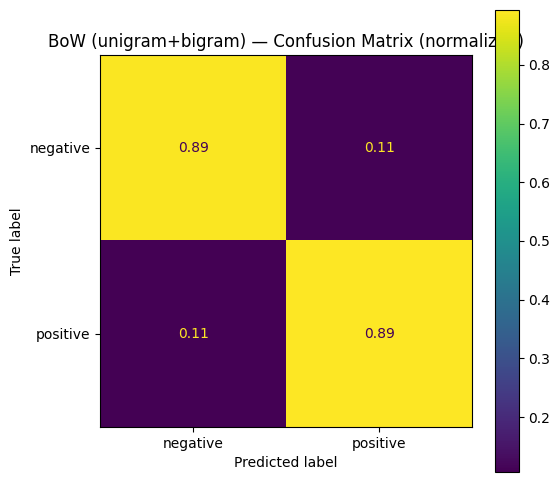

Saved vectorizer + model to: /content/drive/MyDrive/capstone_models


In [8]:
# CELL — BoW + n-grams (CountVectorizer) + Logistic Regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import os

# 1) Vectorize (unigram + bigram)
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=20000)  # tune max_features if needed
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow  = vectorizer.transform(X_test)

# 2) Train classifier
clf_bow = LogisticRegression(max_iter=500, n_jobs=-1)
clf_bow.fit(X_train_bow, y_train)

# 3) Predict & evaluate
pred_bow = clf_bow.predict(X_test_bow)
acc = accuracy_score(y_test, pred_bow)
macro_f1 = f1_score(y_test, pred_bow, average='macro')

print("BoW + ngram Results")
print("--------------------")
print("Accuracy : {:.4f}".format(acc))
print("Macro F1 : {:.4f}".format(macro_f1))
print("\nClassification Report:\n")
print(classification_report(y_test, pred_bow))

# 4) Confusion matrix plot
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, pred_bow, ax=ax, normalize='true')
plt.title("BoW (unigram+bigram) — Confusion Matrix (normalized)")
plt.show()

# 5) Save vectorizer + model to Drive
save_dir = '/content/drive/MyDrive/capstone_models'
os.makedirs(save_dir, exist_ok=True)
joblib.dump(vectorizer, os.path.join(save_dir, 'bow_vectorizer.joblib'))
joblib.dump(clf_bow, os.path.join(save_dir, 'bow_logreg.joblib'))
print(f"Saved vectorizer + model to: {save_dir}")


TF-IDF + ngram Results
-----------------------
Accuracy : 0.9058
Macro F1 : 0.9058

Classification Report:

              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



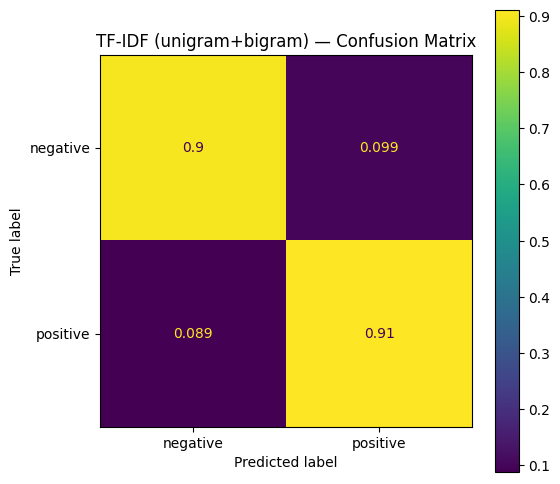

Saved TF-IDF vectorizer + model to: /content/drive/MyDrive/capstone_models


In [9]:
# TF-IDF + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import os

# 1) Vectorize with TF-IDF (unigram + bigram)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# 2) Train classifier
clf_tfidf = LogisticRegression(max_iter=500, n_jobs=-1)
clf_tfidf.fit(X_train_tfidf, y_train)

# 3) Predict & evaluate
pred_tfidf = clf_tfidf.predict(X_test_tfidf)
acc = accuracy_score(y_test, pred_tfidf)
macro_f1 = f1_score(y_test, pred_tfidf, average='macro')

print("TF-IDF + ngram Results")
print("-----------------------")
print("Accuracy : {:.4f}".format(acc))
print("Macro F1 : {:.4f}".format(macro_f1))
print("\nClassification Report:\n")
print(classification_report(y_test, pred_tfidf))

# Confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, pred_tfidf, ax=ax, normalize='true')
plt.title("TF-IDF (unigram+bigram) — Confusion Matrix")
plt.show()

# Save model + vectorizer
save_dir = '/content/drive/MyDrive/capstone_models'
os.makedirs(save_dir, exist_ok=True)
joblib.dump(tfidf, os.path.join(save_dir, 'tfidf_vectorizer.joblib'))
joblib.dump(clf_tfidf, os.path.join(save_dir, 'tfidf_logreg.joblib'))
print(f"Saved TF-IDF vectorizer + model to: {save_dir}")


In [10]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip -O /content/drive/MyDrive/glove.6B.zip

!unzip -n /content/drive/MyDrive/glove.6B.zip -d /content/drive/MyDrive/glove.6B


File ‘/content/drive/MyDrive/glove.6B.zip’ already there; not retrieving.
Archive:  /content/drive/MyDrive/glove.6B.zip


In [11]:
import numpy as np

# Path to the GloVe file you unzipped
glove_path = "/content/drive/MyDrive/glove.6B/glove.6B.100d.txt"

def load_glove(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove(glove_path)
embedding_dim = len(next(iter(glove.values())))
print("Loaded GloVe with dimension:", embedding_dim)
print("Total words loaded:", len(glove))


Loaded GloVe with dimension: 100
Total words loaded: 400000


In [12]:

#Convert Each Text to an Embedding Vector
def sentence_vector_glove(text):
      words = text.split()
      vectors = [glove[w] for w in words if w in glove]
      if len(vectors) == 0:
          return np.zeros(embedding_dim)  # empty sentence fallback
      return np.mean(vectors, axis=0)

# Convert all texts
X_train_glove = np.vstack([sentence_vector_glove(t) for t in X_train])
X_test_glove  = np.vstack([sentence_vector_glove(t) for t in X_test])

print("Train vectors shape:", X_train_glove.shape)
print("Test vectors shape :", X_test_glove.shape)

Train vectors shape: (40000, 100)
Test vectors shape : (10000, 100)


In [13]:
# Train & Evaluate GloVe Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

clf_glove = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
 )

clf_glove.fit(X_train_glove, y_train)
pred_glove = clf_glove.predict(X_test_glove)

acc = accuracy_score(y_test, pred_glove)
f1 = f1_score(y_test, pred_glove, average='macro')

print("GloVe Embedding Results")
print("------------------------")
print("Accuracy:", acc)
print("Macro F1:", f1)
print("\nClassification Report:\n")
print(classification_report(y_test, pred_glove))


GloVe Embedding Results
------------------------
Accuracy: 0.771
Macro F1: 0.7709874592732698

Classification Report:

              precision    recall  f1-score   support

    negative       0.78      0.76      0.77      5000
    positive       0.77      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [14]:
# ===== Word2Vec: train on your training corpus =====
# (run this cell)
!pip install -q gensim

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

# Prepare tokenized sentences from training data
sentences = [simple_preprocess(text) for text in X_train]

# Train Word2Vec (you can change vector_size, window, epochs)
w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    seed=42
                            )

print("Word2Vec trained. Vocab size:", len(w2v_model.wv), "Vector size:", w2v_model.vector_size)

# Convert sentences to averaged Word2Vec vectors
def sentence_vector_w2v(text):
    words = simple_preprocess(text)
    vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack([sentence_vector_w2v(t) for t in X_train])
X_test_w2v  = np.vstack([sentence_vector_w2v(t) for t in X_test])

print("Shapes -> X_train_w2v:", X_train_w2v.shape, "X_test_w2v:", X_test_w2v.shape)


Word2Vec trained. Vocab size: 56732 Vector size: 100
Shapes -> X_train_w2v: (40000, 100) X_test_w2v: (10000, 100)


Word2Vec Embedding Results
---------------------------
Accuracy: 0.8593
Macro F1: 0.8592997622165981

Classification Report:

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      5000
    positive       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



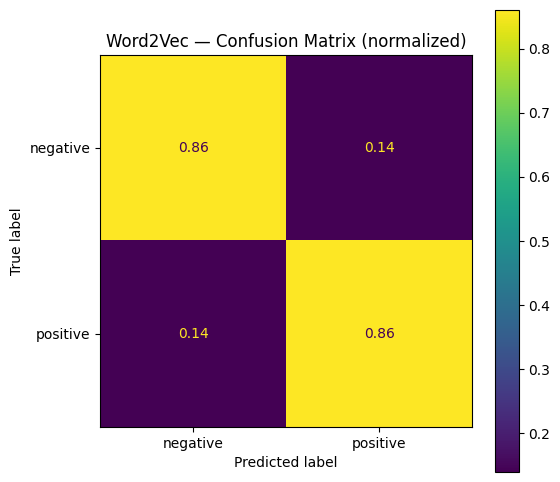

Saved Word2Vec classifier to: /content/drive/MyDrive/capstone_models


In [15]:
# ===== Train & evaluate classifier on Word2Vec vectors =====
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import joblib, os
import matplotlib.pyplot as plt

save_dir = '/content/drive/MyDrive/capstone_models'
os.makedirs(save_dir, exist_ok=True)

clf_w2v = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
clf_w2v.fit(X_train_w2v, y_train)
pred_w2v = clf_w2v.predict(X_test_w2v)

acc_w2v = accuracy_score(y_test, pred_w2v)
f1_w2v = f1_score(y_test, pred_w2v, average='macro')

print("Word2Vec Embedding Results")
print("---------------------------")
print("Accuracy:", acc_w2v)
print("Macro F1:", f1_w2v)
print("\nClassification Report:\n")
print(classification_report(y_test, pred_w2v))

# Confusion matrix (normalized)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, pred_w2v, ax=ax, normalize='true')
plt.title("Word2Vec — Confusion Matrix (normalized)")
plt.show()

# Save model
joblib.dump(clf_w2v, os.path.join(save_dir, 'w2v_logreg.joblib'))
print("Saved Word2Vec classifier to:", save_dir)


In [16]:
# Install if needed (it may already be installed)
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer
import numpy as np

# Use a fast, high-quality model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode train + test (batch_size helps memory)
X_train_bert = bert_model.encode(list(X_train), show_progress_bar=True, convert_to_numpy=True, batch_size=64)
X_test_bert  = bert_model.encode(list(X_test),  show_progress_bar=True, convert_to_numpy=True, batch_size=64)

print("BERT shapes:", X_train_bert.shape, X_test_bert.shape)








/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

BERT shapes: (40000, 384) (10000, 384)


In [17]:
# BERT encoding (SentenceTransformer)
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer
import numpy as np

bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # public model, token not required

# Encode (batch_size 64 is safe; reduce if you hit memory issues)
X_train_bert = bert_model.encode(list(X_train), show_progress_bar=True, convert_to_numpy=True, batch_size=64)
X_test_bert  = bert_model.encode(list(X_test),  show_progress_bar=True, convert_to_numpy=True, batch_size=64)

print("BERT shapes ->", X_train_bert.shape, X_test_bert.shape)


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

BERT shapes -> (40000, 384) (10000, 384)


BERT Embedding Results
----------------------
Accuracy: 0.8295
Macro F1: 0.8295

Classification Report:

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      5000
    positive       0.83      0.83      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



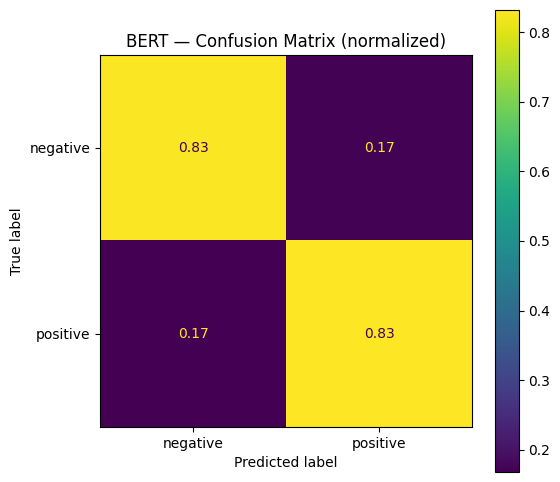

Saved BERT classifier to: /content/drive/MyDrive/capstone_models


In [18]:
# Train & evaluate classifier on BERT embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib, os

save_dir = '/content/drive/MyDrive/capstone_models'
os.makedirs(save_dir, exist_ok=True)

clf_bert = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
clf_bert.fit(X_train_bert, y_train)
pred_bert = clf_bert.predict(X_test_bert)

acc_bert = accuracy_score(y_test, pred_bert)
f1_bert = f1_score(y_test, pred_bert, average='macro')

print("BERT Embedding Results")
print("----------------------")
print(f"Accuracy: {acc_bert:.4f}")
print(f"Macro F1: {f1_bert:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, pred_bert))

# Confusion matrix (normalized)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, pred_bert, ax=ax, normalize='true')
plt.title("BERT — Confusion Matrix (normalized)")
plt.show()

# Save classifier
joblib.dump(clf_bert, os.path.join(save_dir, 'bert_logreg.joblib'))
print("Saved BERT classifier to:", save_dir)


           Method   MacroF1  Accuracy
0          TF-IDF  0.905797    0.9058
1      BoW(ngram)  0.891099    0.8911
2  Word2Vec(100d)  0.859300    0.8593
3   BERT (MiniLM)  0.829499    0.8295
4     GloVe(100d)  0.770987    0.7710


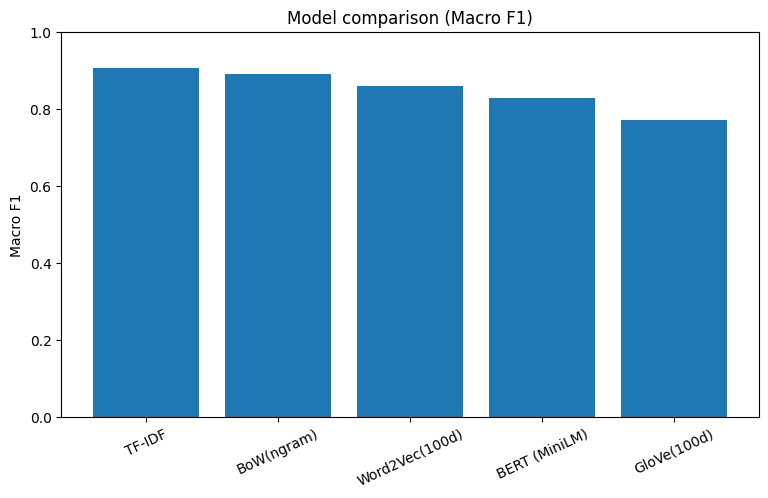

Saved comparison table to: /content/drive/MyDrive/capstone_models/model_comparison.csv


In [19]:
# Final comparison table + bar plot
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

methods = []
macrof1s = []
accuracies = []

# helper to add entry (skip if variable missing)
def add_result(name, preds):
    methods.append(name)
    macrof1s.append(f1_score(y_test, preds, average='macro'))
    accuracies.append(accuracy_score(y_test, preds))

# Add each model (wrap in try/except so cell won't error if a variable missing)
try: add_result('BoW(ngram)', pred_bow)
except: print("Warning: pred_bow not found — skip BoW entry")
try: add_result('TF-IDF', pred_tfidf)
except: print("Warning: pred_tfidf not found — skip TF-IDF entry")
try: add_result('GloVe(100d)', pred_glove)
except: print("Warning: pred_glove not found — skip GloVe entry")
try: add_result('Word2Vec(100d)', pred_w2v)
except: print("Warning: pred_w2v not found — skip Word2Vec entry")
try: add_result('BERT (MiniLM)', pred_bert)
except: print("Warning: pred_bert not found — skip BERT entry")

res_df = pd.DataFrame({
    'Method': methods,
    'MacroF1': macrof1s,
    'Accuracy': accuracies
}).sort_values('MacroF1', ascending=False).reset_index(drop=True)

print(res_df)
# Plot
plt.figure(figsize=(9,5))
plt.bar(res_df['Method'], res_df['MacroF1'])
plt.ylim(0,1)
plt.title("Model comparison (Macro F1)")
plt.ylabel("Macro F1")
plt.xticks(rotation=25)
plt.show()

# Save CSV and show path
res_path = os.path.join(save_dir, 'model_comparison.csv')
res_df.to_csv(res_path, index=False)
print("Saved comparison table to:", res_path)

#loading dataset